# <font color="red"> CellProfiler: Quantification of cytoplasmic/Nuc TDP-43 in Alyssa Coyne neurons </font>

JIRA task: NN-54

Why Linear Mixed-Effects Models (LMMs)?
Your experimental structure involves:

- Measurements per site image (the dependent variable)

- Patients as subjects, with 10 repeated measures (site images) per patient

- Gene group as the fixed effect of interest (WT, C9, +sALS, -sALS)

- Random variation across patients, potentially nested in gene groups

This design includes both fixed effects (gene group) and random effects (patient) — perfect for LMMs.



NOTE:

If mixed model fails (e.g., singular random effects, low variance), we fall back to a fixed-effects model 
where we fit:
ols("feature_value ~ C(gene_group) + C(patient_id)", data=...)
In this model, we estimates how gene groups differ from a reference group (C(gene_group)) after **adjusting** for per-patient shifts (C(patient_id), batch correction)
Residual error:	Site-to-site variation within a patient. You're estimating how gene groups affect the measurement, controlling for (not modeling) patient variability. Each patient gets its own intercept, but you don't estimate a variance across patients (like in mixed models)


In [1]:
from pathlib import Path
import glob
import sys
import os


os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA/'
os.environ['NOVA_DATA_HOME'] = f"{os.environ['NOVA_HOME']}/input"
print('NOVA_HOME is at', os.getenv('NOVA_HOME'))
sys.path.insert(1, os.getenv('NOVA_HOME'))


import numpy as np
import pandas as pd
import seaborn as sns
from markdown import markdown
import matplotlib.pyplot as plt

from cell_profiler.code.cp_effect_size_utils import CP_OUTPUTS_FOLDER, validate_cp_files, extract_path_parts, merge_on_group, collect_cp_results_by_cell_line, load_cp_results, get_features_per_image, get_aggregated_features_per_image, get_aggregated_features_per_image, assign_gene_group_Coyne_new, assign_plate_Coyne_new, assign_gene_group_Coyne_old, run_analysis_generate_report, print_mixedlm_conclusions
from manuscript.plot_config import PlotConfig

%load_ext autoreload    
%autoreload 2

NOVA_HOME is at /home/projects/hornsteinlab/Collaboration/NOVA/


# <font color="blue">Old Coyne dataset</font>

In [2]:
ANALYSIS_TYPE = 'TDP_localization/coyne_old_TDP43'   
BATCHES = ['batch1']

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne/cell_profiler/TDP_localization/coyne_old_TDP43'


In [3]:
group_by_columns = ['ImageNumber', 'batch', 'rep', 'cell_line']
cp_measures_cols = ["Math_cyto_over_nuc"]

In [4]:
# Test CP outputs (number of images)
if False:
    pattern = os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, '*', '*', '*', '*', '*', '*')
    # store marker folders by cell line
    for marker_path in glob.glob(pattern):
        if os.path.isdir(marker_path):
            try:
                image_df = pd.read_csv(marker_path +'/Image.csv')
                print(marker_path, image_df.shape)
                #print(image_df[['Count_Pbodies', 'Count_nucleus']].head(10))

#                 parts_df = image_df['URL_DAPI'].apply(extract_path_parts)
#                 print(marker_path, parts_df['rep'].unique(), parts_df['cell_line'].unique())

                marker = os.path.basename(marker_path)    
                cell_line = Path(marker_path).resolve().parents[3].name
            except FileNotFoundError as e:
                print("!!!!")
                print(e)
        else:
            print(f"Not a marker folder directory:{marker_path}")


## Collect CP files by "cell_line" (paths_by_cell_line[cell_line]) and Load CP data

In [5]:
# Collect paths of CP output files
paths_by_cell_line = collect_cp_results_by_cell_line(ANALYSIS_TYPE, include_condition=False, validate=False)

In [6]:
# Load CP data
cp_data = load_cp_results(paths_by_cell_line, REQUIRED_FILES=['Cytoplasm.csv'])


number of subjects from cell line c9orf72ALSPatients: 3
number of subjects from cell line sALSNegativeCytoTDP43: 2
number of subjects from cell line Controls: 6
number of subjects from cell line sALSPositiveCytoTDP43: 10


In [7]:
# Get the calculated features from CP output files

dfs = []
for cell_line in cp_data:

    # 'Cytoplasm.csv'
    pb_cyto_site_means = get_aggregated_features_per_image(
        cp_file_name='Cytoplasm.csv', 
        measurement_cols=cp_measures_cols, 
        cp_data=cp_data, 
        cell_line=cell_line, 
        group_by_columns=group_by_columns, 
        agg_function=np.mean
     )
    
    dfs.append(pb_cyto_site_means)

cp_measurements = pd.concat(dfs, ignore_index=True)
print("Shape after merging is:", cp_measurements.shape)        


Shape after merging is: (210, 5)


In [8]:
# Add patient_id
cp_measurements['patient_id'] = cp_measurements['cell_line']+"_"+cp_measurements['rep']

# Add gene_group
cp_measurements['gene_group'] = cp_measurements['cell_line'].apply(assign_gene_group_Coyne_old)

# Fiilter by lines
lines_to_include = ["Ctrl", "C9", "SALSNegative", "SALSPositive"]
cp_measurements = cp_measurements[cp_measurements['gene_group'].isin(lines_to_include)]
print(cp_measurements.shape)

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
cp_measurements["gene_group"] = pd.Categorical(
    cp_measurements["gene_group"],
    categories=lines_to_include,
    ordered=True
)


(210, 7)


In [9]:
cp_measurements[['rep', 'cell_line']].value_counts()


rep    cell_line            
rep1   Controls                 10
       c9orf72ALSPatients       10
       sALSNegativeCytoTDP43    10
       sALSPositiveCytoTDP43    10
rep10  sALSPositiveCytoTDP43    10
rep2   Controls                 10
       c9orf72ALSPatients       10
       sALSNegativeCytoTDP43    10
       sALSPositiveCytoTDP43    10
rep3   Controls                 10
       c9orf72ALSPatients       10
       sALSPositiveCytoTDP43    10
rep4   Controls                 10
       sALSPositiveCytoTDP43    10
rep5   Controls                 10
       sALSPositiveCytoTDP43    10
rep6   Controls                 10
       sALSPositiveCytoTDP43    10
rep7   sALSPositiveCytoTDP43    10
rep8   sALSPositiveCytoTDP43    10
rep9   sALSPositiveCytoTDP43    10
Name: count, dtype: int64

In [10]:
cp_measurements[['patient_id']].value_counts()

patient_id                 
Controls_rep1                  10
Controls_rep2                  10
Controls_rep3                  10
Controls_rep4                  10
Controls_rep5                  10
Controls_rep6                  10
c9orf72ALSPatients_rep1        10
c9orf72ALSPatients_rep2        10
c9orf72ALSPatients_rep3        10
sALSNegativeCytoTDP43_rep1     10
sALSNegativeCytoTDP43_rep2     10
sALSPositiveCytoTDP43_rep1     10
sALSPositiveCytoTDP43_rep10    10
sALSPositiveCytoTDP43_rep2     10
sALSPositiveCytoTDP43_rep3     10
sALSPositiveCytoTDP43_rep4     10
sALSPositiveCytoTDP43_rep5     10
sALSPositiveCytoTDP43_rep6     10
sALSPositiveCytoTDP43_rep7     10
sALSPositiveCytoTDP43_rep8     10
sALSPositiveCytoTDP43_rep9     10
Name: count, dtype: int64

In [11]:
cp_measurements[['gene_group']].value_counts()

gene_group  
SALSPositive    100
Ctrl             60
C9               30
SALSNegative     20
Name: count, dtype: int64

# Effect size modeling

The terms in the formula:
- measurement: The CellProfiler feature (e.g., mean number of p-bodies).
- gene_group: A fixed effect to test differences between WT, C9, +sALS, -sALS.
- rep: Random intercept for each patient, accounting for intra-patient correlation across site images.

What This Model Gives You:
- Estimates of group differences: WT vs other groups, with significance testing.

- Within-patient variability: Captures how consistent measurements are across images for a given patient.

- Between-patient variability: Tests whether observed effects are reproducible across patients.

- P-values or confidence intervals: For significance of gene group effects.



In [12]:
#cp_measurements[['patient_id', 'mean_Math_cyto_over_nuc']].groupby('patient_id').describe()
cp_measurements[['gene_group', 'mean_Math_cyto_over_nuc']].groupby('gene_group', observed=False).describe()

mean_Math_cyto_over_nuc                                          \
                               count      mean       std       min       25%   
gene_group                                                                     
Ctrl                            60.0  0.526185  0.068104  0.353459  0.483185   
C9                              30.0  0.802477  0.134455  0.580053  0.692677   
SALSNegative                    20.0  0.591194  0.138631  0.371656  0.458626   
SALSPositive                   100.0  0.686001  0.112704  0.460055  0.613205   

                                            
                   50%       75%       max  
gene_group                                  
Ctrl          0.520947  0.568062  0.734804  
C9            0.779780  0.920648  1.080519  
SALSNegative  0.611273  0.679712  0.839442  
SALSPositive  0.661506  0.732666  1.088939

In [17]:
# get the CellProfiler features you want to calculate effect for 
cp_features_columns = [col for col in cp_measurements.columns if col not in group_by_columns + ['patient_id', 'gene_group']]

results_df_coyne_old = run_analysis_generate_report(
                                df=cp_measurements,
                                feature_columns=cp_features_columns,
                                group_col="gene_group",
                                batch_col="patient_id",
                                output_dir=os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, 'mixed_effect_report'),
                                cov_type="cluster"
)

results_df_coyne_old





Analysing CP feature: mean_Math_cyto_over_nuc
⚠️ Fallback to fixed-effects model for feature: mean_Math_cyto_over_nuc with cov_type=cluster
                            OLS Regression Results                            
Dep. Variable:          feature_value   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     18.61
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           5.26e-06
Time:                        22:08:39   Log-Likelihood:                 170.65
No. Observations:                 210   AIC:                            -333.3
Df Residuals:                     206   BIC:                            -319.9
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                    coef    std err          z     

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _, results_df_wo_intercept["fdr_pval_global"], _, _ = multipletests(results_df_wo_intercept["pval"], method="fdr_bh")


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,mean_Math_cyto_over_nuc,Intercept,0.526185,2.324742e-193,0.491417,0.560952,NaN,0.01175,****,fallback_ols_fixed_batch_cov_type+cluster,True,-333.295895,-319.907465,170.647948,0.428535,NaN
1,mean_Math_cyto_over_nuc,C9,0.276292,9.206646e-08,0.174916,0.377668,NaN,0.01175,****,fallback_ols_fixed_batch_cov_type+cluster,True,-333.295895,-319.907465,170.647948,0.428535,1.380997e-07
2,mean_Math_cyto_over_nuc,SALSNegative,0.065010,2.173554e-01,-0.038280,0.168299,NaN,0.01175,ns,fallback_ols_fixed_batch_cov_type+cluster,True,-333.295895,-319.907465,170.647948,0.428535,2.173554e-01
3,mean_Math_cyto_over_nuc,SALSPositive,0.159817,2.418264e-10,0.110349,0.209284,NaN,0.01175,****,fallback_ols_fixed_batch_cov_type+cluster,True,-333.295895,-319.907465,170.647948,0.428535,7.254792e-10


## Plot

In [19]:

def plot_cp_feature_grouped_by_gene(cp_measurements, cp_feature_col, group_col="gene_group", patient_col="patient_id", color_mapping=None, model_results_df=None, save_path=None):
    
    df = cp_measurements.copy()

    # Define fixed color and label mapping for both group_col and patient_col
    groups = df[group_col].astype(str).unique().tolist() + df[patient_col].astype(str).unique().tolist()
    _palette = {}
    for g in groups:
        if g in color_mapping: _palette[color_mapping[g]['alias']] = color_mapping[g]['color']
    if patient_col=='batch':
        for b in df[patient_col].astype(str).unique().tolist():
            _palette[b]='gray'

    # Rename groups to aliases
    label_mapping = {k: v["alias"] for k, v in color_mapping.items() if k in groups}
    df[group_col] = df[group_col].cat.rename_categories(label_mapping)
    df[patient_col] = df[patient_col].astype("category").cat.rename_categories(label_mapping)
    
    # Determine group order and x-axis positions for each group 
    groups_order = sorted(df[group_col].unique(), reverse=False)
    x_spacing = 0.4
    x_pos_map = {label: i * x_spacing for i, label in enumerate(groups_order)}
    
    # Setup plot
    sns.set(style="white", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(3, 4))
    line_width = 1
    
    # ============================
    # Plot each group manually by numeric x
    # ============================
    for i, group in enumerate(groups_order):
        
        group_data = df[df[group_col] == group]
        xpos = x_pos_map[group]
        
        # Boxplot for group
        sns.boxplot(
            data=group_data,
            y=cp_feature_col,
            hue=group_col, #patient_col,
            ax=ax,
            width=0.3,
            linewidth=line_width,
            showfliers=False,
            showmeans=True,
            meanline=True,
            meanprops={"linestyle": "-", "color": "black", "linewidth": line_width},
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=line_width),
            whiskerprops=dict(linewidth=line_width-0.3, color='black'),
            capprops=dict(linewidth=line_width, color='black'),
            medianprops=dict(visible=False),
            positions=[x_pos_map[group]]
        )
        
        # ============================
        # Full distribution: raw cell-level/image-level points (light gray)
        # ============================ 
        patient_ids = group_data[patient_col].unique()
        for i, patient in enumerate(patient_ids):
            patient_data = group_data[group_data[patient_col] == patient]

            ax.scatter(
                x=np.random.normal(loc=x_pos_map[group], scale=0.05, size=len(patient_data)),  # jitter
                y=patient_data[cp_feature_col],
                color=_palette.get(patient, 'black'),#'lightgray',
                s=2.5,
                alpha=0.3,
                zorder=1
            )

    # ============================
    # Overlay per-patient means (means as colored points)
    # ============================
    patient_means = df.groupby([group_col, patient_col], observed=True)[cp_feature_col].mean().reset_index()

    for _, row in patient_means.iterrows():
        group = row[group_col]
        patient = row[patient_col]

        # Skip if value is missing
        if pd.isna(group) or pd.isna(patient) or pd.isna(row[cp_feature_col]):
            continue
        
        xpos = x_pos_map.get(group)
        y = row[cp_feature_col]

        if pd.isna(xpos) or pd.isna(y):
            continue

        jittered_x = np.random.normal(loc=xpos, scale=0.05)
        
        ax.scatter(
            x=jittered_x,
            y=y,
            color=_palette.get(patient, 'black'),
            edgecolor=None,
            s=10,
            zorder=3,
            label=patient
        )

    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(
        unique.values(),
        unique.keys(),
        title=patient_col,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )
    
    # Set axis formatting
    ax.set_xlim(-x_spacing+0.1, max(x_pos_map.values()) + x_spacing - 0.1)
    
    ax.set_xticks(list(x_pos_map.values()))
    ax.set_xticklabels(groups_order, rotation=90)
    ax.set_ylabel(cp_feature_col)
    ax.margins(x=0)
    
    # Ensure tick marks are shown on both axes
    ax.tick_params(axis='both', which='both', direction='out',
                   length=4, width=1, bottom=True, top=False, left=True, right=False)
    

    # ============================
    # P-value annotation LMM
    # ============================
    # Overlay effect sizes + p-values if model results are available
    if model_results_df is not None:
        # Filter for this feature
        res_df = model_results_df[model_results_df["feature"] == cp_feature_col].copy()
        
        # Rename CSV values
        res_df['comparison'] = pd.Categorical(res_df['comparison'])
        res_df['comparison'] = res_df['comparison'].cat.rename_categories(label_mapping)
    

        xtick_positions = ax.get_xticks()
        xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

        for xtick_pos, group_label in zip(xtick_positions, xtick_labels):
            
            if group_label == xtick_labels[0]:
                continue  # Skip Intercept (reference)

            res_row = res_df[res_df["comparison"] == group_label].copy()
            if not res_row.empty:
                est = res_row["effect_size"].values[0]
                p = res_row["pval"].values[0]
                #annotation = f"Δ={est:+.2f}, p={pval:.3f}"

                # Format p display
                if p < 0.001:
                    p_text = "***"
                elif p < 0.01:
                    p_text = "**"
                elif p < 0.05:
                    p_text = "*"
                else:
                    p_text = f"n.s."
                
                x_keys = list(x_pos_map.values())
                x1, x2 = x_keys[0], xtick_pos
                ymin, ymax = ax.get_ylim()
                buffer = 0.05
                if ymax<=1: buffer = 0.005
                y_range = ymax - ymin
                line_y = ymax - buffer * xtick_pos
                text_y = line_y + 0.01 * y_range

                ax.plot([x1, x1, x2, x2],
                [line_y, line_y + 0.01*y_range, 
                 line_y + 0.01*y_range, line_y],
                lw=1.5, c='black')

                ax.text(
                    (x1 + xtick_pos)/2,
                    text_y,
                    p_text,
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color="black")
                
    # Remove extra space around plot
    plt.tight_layout()
    # Add top space if needed
    #plt.subplots_adjust(top=0.8)
    #plt.suptitle(txt, fontsize=8)
    
    # Save the plot
    if save_path is not None:
        # Save the plot
        plt.savefig(f"{save_path}/cell_profiler_Coyne_cyto_TDP43.pdf", dpi=300)
        plt.savefig(f"{save_path}/cell_profiler_Coyne_cyto_TDP43.png", dpi=300)

        
        
        plt.show()
        plt.close(fig)
    else:
        plt.show()



/tmp/ipykernel_3192701/1827488854.py:188: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


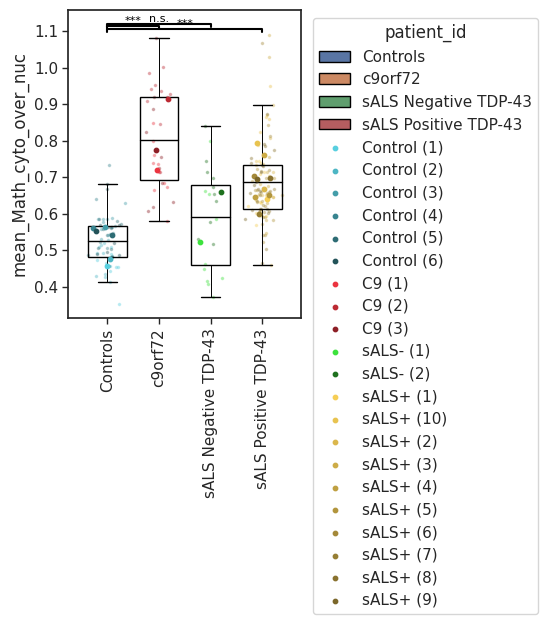

In [20]:
plot_cp_feature_grouped_by_gene(cp_measurements, 
                                      cp_feature_col="mean_Math_cyto_over_nuc",
                                      group_col='gene_group', 
                                      patient_col="patient_id",
                                      color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA,
                                      model_results_df=results_df_coyne_old, 
                                      save_path=save_path)



### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 

# New Coyne dataset

In [18]:
ANALYSIS_TYPE = 'TDP_localization/coyne_new_TDP43'
BATCHES = ['batch1']

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/AlyssaCoyne_new/cell_profiler/TDP_localization/coyne_new_TDP43'


In [19]:
# Test CP outputs (number of images)
if True:
    pattern = os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, '*', '*', '*', '*', '*', '*')
    # store marker folders by cell line
    for marker_path in glob.glob(pattern):
        if os.path.isdir(marker_path):
            try:
                image_df = pd.read_csv(marker_path +'/Image.csv')
                print(marker_path, image_df.shape)
               
                marker = os.path.basename(marker_path)    
                cell_line = Path(marker_path).resolve().parents[3].name
            except FileNotFoundError as e:
                print("!!!!")
                print(e)
        else:
            print(f"Not a marker folder directory:{marker_path}")


/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/coyne_new_TDP43/batch1/C9-CS7VCZ/panelA/Untreated/rep1/TDP43 (5, 168)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/coyne_new_TDP43/batch1/C9-CS7VCZ/panelA/Untreated/rep2/TDP43 (5, 168)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/coyne_new_TDP43/batch1/C9-CS8RFT/panelA/Untreated/rep1/TDP43 (5, 168)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/coyne_new_TDP43/batch1/C9-CS8RFT/panelA/Untreated/rep2/TDP43 (5, 168)
/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/outputs/cell_profiler_RUNS/Final_cp_analysis/TDP_localization/coyne_new_TDP43/batch1/Ctrl-EDi029/panelA/Untreated/rep1/TDP43 (5, 168)
/home/projects/hornsteinlab/Colla

## Collect CP files by "cell_line" (paths_by_cell_line[cell_line])

In [20]:
# Collect paths of CP output files
paths_by_cell_line = collect_cp_results_by_cell_line(ANALYSIS_TYPE, include_condition=False, validate=False)


In [21]:
# Load CP data
cp_data = load_cp_results(paths_by_cell_line, REQUIRED_FILES=['Cytoplasm.csv'])


number of subjects from cell line C9-CS7VCZ: 2
number of subjects from cell line C9-CS8RFT: 2
number of subjects from cell line Ctrl-EDi029: 2
number of subjects from cell line SALSPositive-CS2FN3: 2
number of subjects from cell line SALSNegative-CS0ANK: 2
number of subjects from cell line Ctrl-EDi022: 2
number of subjects from cell line SALSNegative-CS6ZU8: 2
number of subjects from cell line SALSPositive-CS7TN6: 2
number of subjects from cell line SALSNegative-CS0JPP: 2
number of subjects from cell line Ctrl-EDi037: 2
number of subjects from cell line SALSPositive-CS4ZCD: 2
number of subjects from cell line C9-CS2YNL: 2


In [22]:
# Get the calculated features from CP output files

dfs = []
for cell_line in cp_data:

    # 'Cytoplasm.csv'
    pb_cyto_site_means = get_aggregated_features_per_image(
        cp_file_name='Cytoplasm.csv', 
        measurement_cols=cp_measures_cols, 
        cp_data=cp_data, 
        cell_line=cell_line, 
        group_by_columns=group_by_columns, 
        agg_function=np.mean
     )
    
    dfs.append(pb_cyto_site_means)

cp_measurements = pd.concat(dfs, ignore_index=True)
print("Shape after merging is:", cp_measurements.shape)        



Shape after merging is: (120, 5)


In [23]:
# Add patient_id
cp_measurements['patient_id'] = cp_measurements['cell_line']

# Add plate
cp_measurements['plate'] = cp_measurements['cell_line'].apply(assign_plate_Coyne_new)

# Add gene_group
cp_measurements['gene_group'] = cp_measurements['cell_line'].apply(assign_gene_group_Coyne_new)

# Fiilter by lines
lines_to_include = ["Ctrl", "C9", "SALSNegative", "SALSPositive"]
cp_measurements = cp_measurements[cp_measurements['gene_group'].isin(lines_to_include)]
print(cp_measurements.shape)

# Important to put the reference group first in order for mixedlm() - has to be Categorical!
cp_measurements["gene_group"] = pd.Categorical(
    cp_measurements["gene_group"],
    categories=lines_to_include,
    ordered=True
)


(120, 8)


In [24]:
cp_measurements[['rep', 'patient_id']].value_counts()


rep   patient_id         
rep1  C9-CS2YNL              5
      C9-CS7VCZ              5
      C9-CS8RFT              5
      Ctrl-EDi022            5
      Ctrl-EDi029            5
      Ctrl-EDi037            5
      SALSNegative-CS0ANK    5
      SALSNegative-CS0JPP    5
      SALSNegative-CS6ZU8    5
      SALSPositive-CS2FN3    5
      SALSPositive-CS4ZCD    5
      SALSPositive-CS7TN6    5
rep2  C9-CS2YNL              5
      C9-CS7VCZ              5
      C9-CS8RFT              5
      Ctrl-EDi022            5
      Ctrl-EDi029            5
      Ctrl-EDi037            5
      SALSNegative-CS0ANK    5
      SALSNegative-CS0JPP    5
      SALSNegative-CS6ZU8    5
      SALSPositive-CS2FN3    5
      SALSPositive-CS4ZCD    5
      SALSPositive-CS7TN6    5
Name: count, dtype: int64

In [25]:
cp_measurements[['gene_group']].value_counts()

gene_group  
Ctrl            30
C9              30
SALSNegative    30
SALSPositive    30
Name: count, dtype: int64

In [26]:
cp_measurements[['plate']].value_counts()

plate 
plate1    40
plate2    40
plate3    40
Name: count, dtype: int64

In [33]:
# CellProfiler features
cp_features_columns = [col for col in cp_measurements.columns if col not in group_by_columns + ['patient_id', 'plate', 'gene_group']]

results_df_coyne_new = run_analysis_generate_report(
    df=cp_measurements,
    feature_columns=cp_features_columns,
    group_col="gene_group",
    batch_col="patient_id",
    output_dir=os.path.join(CP_OUTPUTS_FOLDER, ANALYSIS_TYPE, 'mixed_effect_report'),
    # cov_type="cluster" # Was no used since using random effect (no multicollinearity  error)
)

results_df_coyne_new




Analysing CP feature: mean_Math_cyto_over_nuc
⚠️ Warning during model fit for feature mean_Math_cyto_over_nuc: UserWarning: Random effects covariance is singular
⚠️ Warning during model fit for feature mean_Math_cyto_over_nuc: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     feature_value
No. Observations:     120         Method:                 ML           
No. Groups:           12          Scale:                  0.0044       
Min. group size:      10          Log-Likelihood:         145.1949     
Max. group size:      10          Converged:              Yes          
Mean group size:      10.0                                             
-----------------------------------------------------------------------
                              Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------

/home/projects/hornsteinlab/Collaboration/NOVA/cell_profiler/code/cp_effect_size_utils.py:437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _, results_df_wo_intercept["fdr_pval_global"], _, _ = multipletests(results_df_wo_intercept["pval"], method="fdr_bh")


,feature,comparison,effect_size,pval,ci_lower,ci_upper,group_var,residual_var,significance,fit_status,used_fixed_model,aic,bic,loglik,r_squared,fdr_pval_global
0,mean_Math_cyto_over_nuc,Intercept,0.717299,2.779739e-156,0.664513,0.770085,0.001732,0.004442,****,mixedlm,False,-278.389763,-261.664813,145.194882,NaN,NaN
1,mean_Math_cyto_over_nuc,C9,0.314768,1.405757e-16,0.240117,0.389419,0.001732,0.004442,****,mixedlm,False,-278.389763,-261.664813,145.194882,NaN,2.108636e-16
2,mean_Math_cyto_over_nuc,SALSNegative,0.054661,1.512535e-01,-0.019990,0.129312,0.001732,0.004442,ns,mixedlm,False,-278.389763,-261.664813,145.194882,NaN,1.512535e-01
3,mean_Math_cyto_over_nuc,SALSPositive,0.320556,3.888125e-17,0.245905,0.395207,0.001732,0.004442,****,mixedlm,False,-278.389763,-261.664813,145.194882,NaN,1.166438e-16


## Plot

In [ ]:
plot_cp_feature_grouped_by_gene(cp_measurements, 
                                      cp_feature_col="mean_Math_cyto_over_nuc",
                                      group_col='gene_group', 
                                      patient_col="patient_id",
                                      color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA,
                                      model_results_df=results_df_coyne_new, 
                                      save_path=save_path)


# for cp_feature_col in ['mean_Math_cyto_over_nuc']:
#     plot_cp_feature_grouped_by_gene(cp_measurements, 
#                                       cp_feature_col=cp_feature_col,
#                                       group_col='gene_group', 
#                                       patient_col="patient_id",
#                                       color_mapping=PlotConfig().COLOR_MAPPINGS_ALYSSA,
#                                       model_results_df=results_df)   

In [ ]:
# NANCY TBD!!!!


# Additional Recommendations
# Check residuals: Ensure assumptions of normality and homoscedasticity are not violated.

# Multiple testing correction: If testing multiple features (e.g., 20 CellProfiler features), apply FDR correction (Benjamini-Hochberg).

# Visualize: Use boxplots or violin plots grouped by gene_group, faceted by patient if needed, to interpret effects.

# Optional Enhancements
# Multiple feature testing: Apply FDR correction using statsmodels.stats.multitest.multipletests

# Model diagnostics: Plot residuals (result.resid) to verify model assumptions

# Batch effect: Add batch as an additional fixed effect if needed: model = smf.mixedlm("measurement ~ gene_group + batch", data, groups=data["patient"])


In [ ]:
print("Done!")